In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from jax.random import PRNGKey

jax.config.update("jax_enable_x64", True)

from maker import yield_maker
from relaxed import infer

plt.rc("figure", figsize=(10.0, 6.0), dpi=120, facecolor="w")

In [3]:
SCALE = 10000

N = 270 * SCALE


def generate_data(key):
    b1 = jax.random.multivariate_normal(
        key, jnp.array([+1.0, +0.0]), np.eye(2), shape=(N // 4,)
    )
    b2 = jax.random.multivariate_normal(
        key, jnp.array([+0.0, +0.0]), np.eye(2), shape=(N // 4,)
    )
    b3 = jax.random.multivariate_normal(
        key, jnp.array([-1.0, -0.0]), np.eye(2), shape=(N // 4,)
    )

    s1 = jax.random.multivariate_normal(
        key, jnp.array([3.0, 0.0]), np.eye(2), shape=(N // 16,)
    )

    return s1, b1, b2, b3


generate_data(PRNGKey(3))

(DeviceArray([[ 4.90405046, -0.7266758 ],
              [ 1.28942088, -0.74284754],
              [ 4.09989767, -2.06812948],
              ...,
              [ 4.85819591, -0.83374926],
              [ 2.37500022, -0.27758679],
              [ 3.69401675, -0.80784194]], dtype=float64),
 DeviceArray([[ 1.51546916, -0.2400614 ],
              [ 1.23443091,  0.93615926],
              [ 0.72055599, -1.48555364],
              ...,
              [ 1.12645416,  0.05913089],
              [ 1.0917895 , -0.63486779],
              [ 1.65900529,  0.34121197]], dtype=float64),
 DeviceArray([[ 0.51546916, -0.2400614 ],
              [ 0.23443091,  0.93615926],
              [-0.27944401, -1.48555364],
              ...,
              [ 0.12645416,  0.05913089],
              [ 0.0917895 , -0.63486779],
              [ 0.65900529,  0.34121197]], dtype=float64),
 DeviceArray([[-0.48453084, -0.2400614 ],
              [-0.76556909,  0.93615926],
              [-1.27944401, -1.48555364],
          

In [7]:
model_maker = yield_maker(generate_data, SCALE=SCALE)
hypotest = infer.make_hypotest(model_maker)
hypotest([0.2, 0.2], model_kwargs=dict(key=PRNGKey(3)), test_mu=1.0)

{'CLs': DeviceArray(0.04837478, dtype=float64)}

In [8]:
def loss(params, model_kwargs):
    return hypotest(params, model_kwargs=model_kwargs, test_mu=1.0)["CLs"]

without plotting:

In [4]:
def grad_descent(current_params, lr=2):
    current_cls, grad = jax.value_and_grad(loss)(current_params)
    params = current_params - grad * lr
    return params, current_params, current_cls, grad


x = jnp.array([0.1, 0.1])
for i in range(50):
    x, current_x, cls, grad = grad_descent(x, lr=8)
    print(cls, current_x)

0.05297020964311039 [0.1 0.1]
0.047800540880968745 [0.56020978 0.10094372]
0.046891740377903446 [0.49661496 0.16145415]
0.04625987567044043 [0.44437328 0.21557956]
0.045913957275826034 [0.41645631 0.26333243]
0.04566889407440855 [0.40463068 0.30682084]
0.04544191108180118 [0.40244011 0.34913677]
0.0451983527421409 [0.40803034 0.39179105]
0.04490068592340468 [0.42231145 0.43645892]
0.04454253084343751 [0.44186317 0.48438172]
0.04411068872288171 [0.46336413 0.53609704]
0.04350748553696948 [0.49095149 0.59438074]
0.04256951777262752 [0.53469933 0.66317567]
0.04117454880677229 [0.58484918 0.74490882]
0.038419987796895594 [0.66523018 0.85109597]
0.03238543789793846 [0.78827049 0.99702477]
0.017103401426052045 [0.98183535 1.22535863]
0.0007757592282113812 [1.26715066 1.57325562]
0.0003741280702778127 [1.30089583 1.63060603]
0.00026069538270467874 [1.31643288 1.65959856]
0.00020255866416163393 [1.32686922 1.68000913]
0.00016630814212614808 [1.33482583 1.69598246]
0.00014131789564286734 [1.341

With plotting!

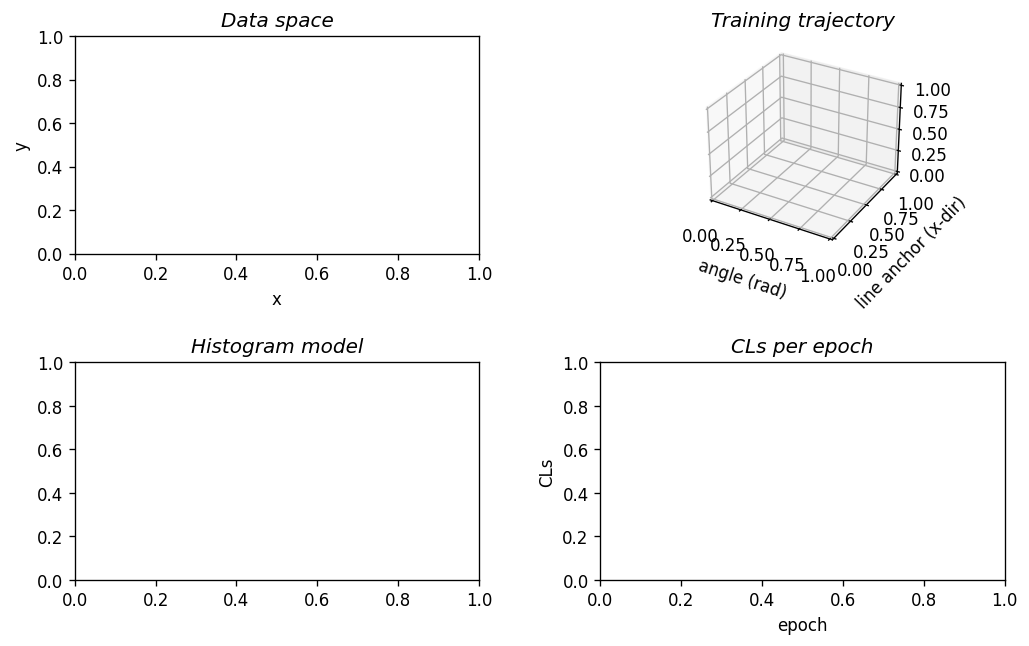

In [86]:
fig, axs = plt.subplot_mosaic(
    [["Data space", "Training trajectory"], ["Histogram model", "CLs per epoch"]]
)

ss = axs["Training trajectory"].get_subplotspec()
axs["Training trajectory"].remove()
axs["Training trajectory"] = fig.add_subplot(ss, projection="3d")

for label, ax in axs.items():
    ax.set_title(label, fontstyle="italic")
axs["Training trajectory"].set_xlabel("angle (rad)")
axs["Training trajectory"].set_ylabel("line anchor (x-dir)")
axs["Data space"].set_xlabel("x")
axs["Data space"].set_ylabel("y")
axs["CLs per epoch"].set_xlabel("epoch")
axs["CLs per epoch"].set_ylabel("CLs")
plt.subplots_adjust(hspace=0.5, wspace=0.3)
fig.set_constrained_layout(False)

# training loop
x = jnp.array([0.1, 0.1])
for i in range(50):
    with temp_seed(i):
        x, current_x, cls, grad = grad_descent(x, lr=8)
        print(cls, current_x)